这个分析笔记由[Jake Vanderplas](http://www.vanderplas.com)编辑汇总。 源代码和license文件在[GitHub](https://github.com/jakevdp/sklearn_tutorial/)。 中文翻译由[派兰数据](http://datarx.cn)在[派兰大数据分析平台](http://www.palandata.com)上完成。 源代码在[GitHub](https://github.com/palandatarxcom/sklearn_tutorial_cn)上。

# 深度探索监督学习：支持向量机

之前我们已经介绍了监督学习。监督学习中有很多算法，在这里我们深入探索其中一种最强大的也最有趣的算法之一：**支持向量机（Support Vector Machines，SVMs）**.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 使用seaborn的一些默认配置
import seaborn as sns; sns.set()

## 支持向量机

支持向量机（SVMs）是监督学习中用来**分类**或者**回归**的最强大的算法之一。支持向量机是一种判别分类器：它可以在数据的集合中画出一条分割线。

我们可以来看一个简单的支持向量机的做分类的例子。首先我们需要创建一个数据集：

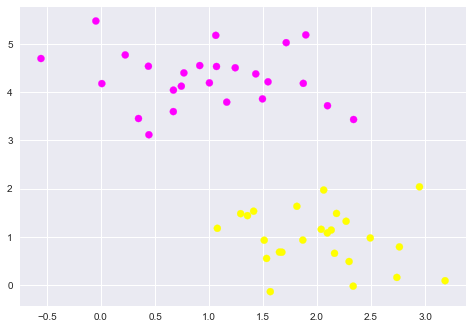

In [2]:
from sklearn.datasets.samples_generator import make_blobs

X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring');

一个判别分类器尝试着去在两组数据间画一条分割线。我们首先需要面临一个问题：这条线的位置很难去定。比如，我们可以找出很多可能的线去将两个数据群体完美的划分：

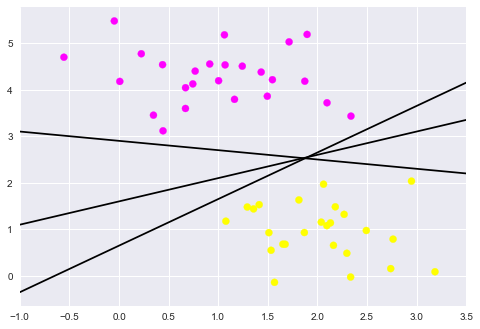

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    #绘制分割线
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

上面的图中有三个各异的分割线，它们都可以将数据集合完美地分隔开来。一个新的数据的分类结果会根据你的选择，得出完全不一样的结果。

我们如何去改进这一点呢？

### 支持向量机：最大化*边界*

支持向量机有一种方法去解决这个问题。支持向量机做的事情不仅仅是画一条线，它还考虑了这条分割线两侧的“区域“的选择。关于这个“区域”是个什么，下面是一个例子：

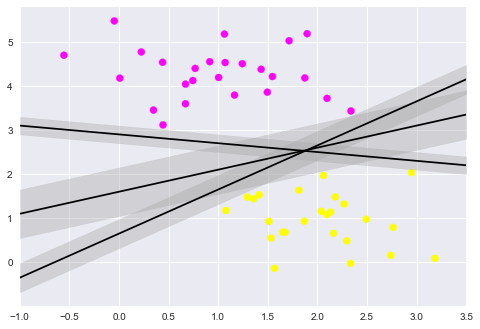

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    #绘制分割线
    plt.plot(xfit, yfit, '-k')
    #绘制分割线两侧的区域
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

注意到，如果我们需要使得直线旁边的区域的宽度达到最大，中间的那条线是最合适的选择。这也就是**支持向量机**的特点和属性，它会优化分隔的直线，使得直线的**边界**与数据集的垂直距离最大。

#### 生成一个支持向量机

现在我们需要根据这些点来生成我们的支持向量机模型。固然生成模型的数学细节很有趣，但是我们想让您在其他地方去了解这些东西。在这里，我们会让您掌握使用scikit-learn的黑盒算法去完成上面的工作。

In [5]:
from sklearn.svm import SVC  # "Support Vector Classifier"

clf = SVC(kernel='linear')
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

为了更好的知道发生了什么，我们创造一个简单方便的函数，去画出SVM算法生成的数据集边界：

In [6]:
def plot_svc_decision_function(clf, ax=None):
    """绘制一个 2D SVC 的决策函数"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([[xi, yj]])
    # 绘制边界
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

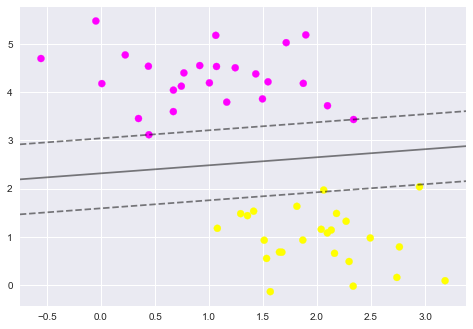

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf);

注意到图中的虚线碰到了一些点：这些点在这次模型的生成中非常重要，它们也就是所谓的*支持向量*。
在scikit-learn中，这些支持向量被存储在分类器的``suppport_vectors_``属性中：

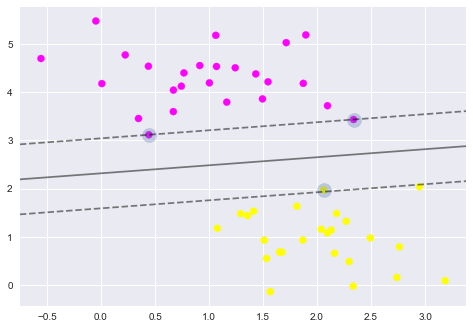

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, alpha=0.3);

让我们使用IPython的``interact``功能去探索这些点的分布是如何影响支持向量和判别模型生成的。
（这个功能只适用于IPython 2.0+，而且在静态视图下无效）

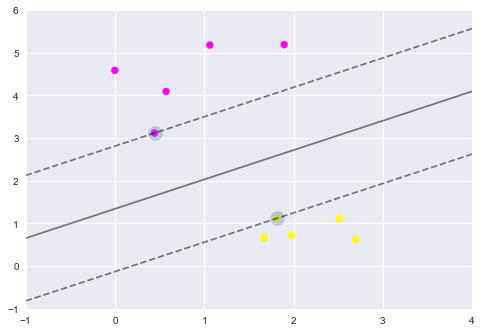

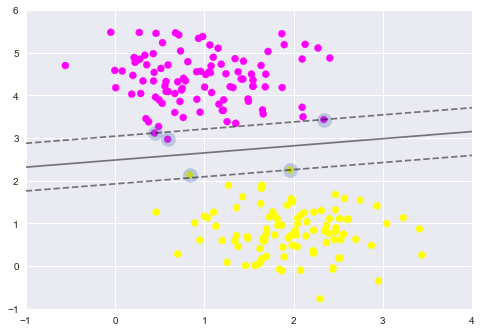

In [9]:
from ipywidgets import interact

def plot_svm(N=10):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    clf = SVC(kernel='linear')
    clf.fit(X, y)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
    plt.xlim(-1, 4)
    plt.ylim(-1, 6)
    plot_svc_decision_function(clf, plt.gca())
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=200, alpha=0.3)
    
interact(plot_svm, N=[10, 200], kernel='linear');

注意到，只有那些支持向量才会影响SVM：如果你移动任意的非支持向量，只要它们不越过边界，对分类的结果就不会有影响。

#### 进一步探索：核方法

当SVM与*核（kernels）*联系起来的时候，它会变得非常有趣。为了进一步的解释“核”是什么，我们去看一些无法被线性分隔的数据。

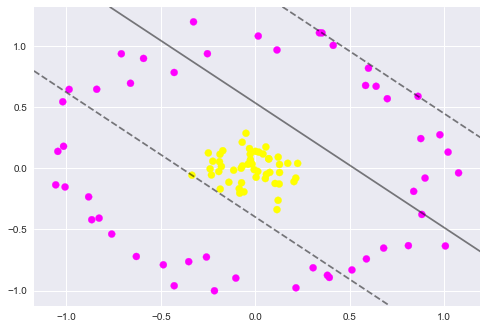

In [10]:
from sklearn.datasets.samples_generator import make_circles

X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf);

很显然，线性的分隔是不能把这些数据隔开的。我们可以通过应用**核方法**去改变，核方法是一些可以转换输入数据的方法。

比如，我们可以使用一个简单的**径向基函数**

In [11]:
r = np.exp(-(X[:, 0] ** 2 + X[:, 1] ** 2))

如果我们连同数据一起去绘图，我们可以看见它的效果：

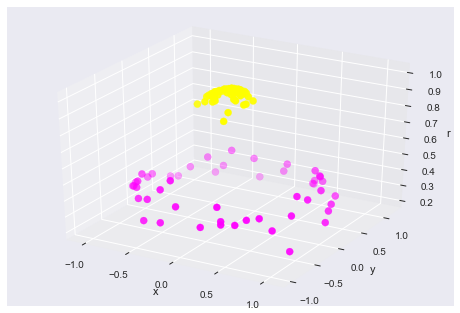

In [12]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='spring')
#     ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

# interact(plot_3D, elev=[-90, 90], azip=(-180, 180));
plot_3D()

我们可以看到，这个增加的维度让我们的数据变得线性可分起来！这是一个相对简单的核方法；SVM有很多更成熟更复杂的集成的方法可供使用。这个方法可以通过使用``kernel='rbf'``来实现，其中rbf是*radial basis function*的缩写：

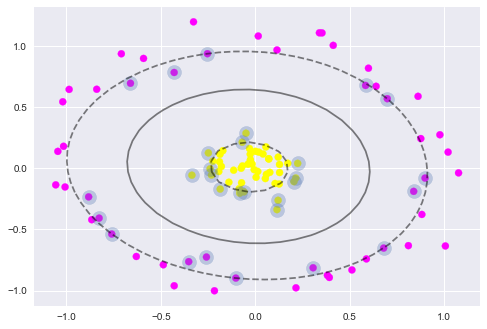

In [13]:
clf = SVC(kernel='rbf')
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, alpha=0.3);

这儿有$N$个有效的基函数：对每一个有灰色阴影圆圈的点。通过"Kernal Trick"这个巧妙的数学技巧，计算显得非常有效率，这种计算方法不用真正的建造核函数度量方法的矩阵。

下面，我们将会离开SVMs环节，来看另外一个分类的算法：随机森林(Random Forests)。